In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
import xgcm
from xgcm.autogenerate import generate_grid_ds
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from dask import compute, delayed

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
#print(cluster.job_script())
#print(cluster.job_header)
w = cluster.scale(10)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

<Client: 'tcp://10.148.1.64:36914' processes=0 threads=0, memory=0 B>

_________
# 1. Read dataset


In [15]:
out_dir_zarr = '/home/datawork-lops-osi/equinox/mit4320/zarr/'
store_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/TAU/'

# read rechunked data
grid = xr.open_zarr(out_dir_zarr+'grid.zarr')
ds_TAUX = xr.open_zarr(out_dir_zarr+'oceTAUX.zarr').rename({'i_g': 'i'}).isel(time=slice(0,100))
ds_TAUY = xr.open_zarr(out_dir_zarr+'oceTAUY.zarr').rename({'j_g': 'j'}).isel(time=slice(0,100))

# data merge
ds = xr.merge([ds_TAUX,ds_TAUY,grid])
print(ds)

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 100)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(100,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-11-23T08:00:00 ... 2011-11-27T11:00:00
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    PHrefC   (k) float32 dask.array<chunksize=(90,), meta=np.ndarray>
    PHrefF   (k_p1) float32 dask.array<chunksize=(91,), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

In [16]:
# coriolis term
lat = ds['YC']
omega = 7.3/100000
f_ij = 2*omega*np.sin(np.deg2rad(lat))
f_ij

<xarray.DataArray 'YC' (face: 13, j: 4320, i: 4320)>
dask.array<mul, shape=(13, 4320, 4320), dtype=float32, chunksize=(1, 4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rA       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

In [7]:
overwrite=True
    
for face in range(13):
#for face in [1]:

    Efile = store_dir_zarr+'ELD_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:
        
        oceTAUX_rotation =  ds.oceTAUX.isel(face=face)*ds.CS.isel(face=face) - ds.oceTAUY.isel(face=face)*ds.SN.isel(face=face)
        oceTAUY_rotation =  ds.oceTAUX.isel(face=face)*ds.SN.isel(face=face) + ds.oceTAUY.isel(face=face)*ds.CS.isel(face=face)
        ELD = 0.2*np.sqrt(np.sqrt(oceTAUX_rotation**2 + oceTAUY_rotation**2)/1025)/np.abs(f_ij.isel(face=face))
        ELD = ELD.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))
        #oceTAUX_H =  oceTAUX_rotation.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/ELD.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/1025
        chunks = {'i': 1080, 'j': 1080}
        ELD = ELD.chunk(chunks)
        
        # store
        ELD = np.real(ELD).rename('ELD')
        ELD = ELD.to_dataset()
        
        for c in ELD.coords:
            try:
                del E[c].encoding['chunks']
            except:
                pass        
        
        %time ELD.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

CPU times: user 2.11 s, sys: 180 ms, total: 2.29 s
Wall time: 16 s
--- face 0 done
CPU times: user 1.59 s, sys: 104 ms, total: 1.7 s
Wall time: 7.88 s
--- face 1 done
CPU times: user 1.54 s, sys: 124 ms, total: 1.66 s
Wall time: 7.28 s
--- face 2 done
CPU times: user 1.46 s, sys: 124 ms, total: 1.58 s
Wall time: 6.8 s
--- face 3 done
CPU times: user 1.6 s, sys: 140 ms, total: 1.74 s
Wall time: 7.91 s
--- face 4 done
CPU times: user 1.49 s, sys: 152 ms, total: 1.64 s
Wall time: 7.64 s
--- face 5 done
CPU times: user 1.56 s, sys: 100 ms, total: 1.66 s
Wall time: 7.36 s
--- face 6 done
CPU times: user 1.69 s, sys: 168 ms, total: 1.86 s
Wall time: 7.73 s
--- face 7 done
CPU times: user 1.58 s, sys: 144 ms, total: 1.72 s
Wall time: 7.72 s
--- face 8 done
CPU times: user 1.52 s, sys: 164 ms, total: 1.68 s
Wall time: 7.56 s
--- face 9 done
CPU times: user 1.53 s, sys: 132 ms, total: 1.66 s
Wall time: 7.17 s
--- face 10 done
CPU times: user 1.53 s, sys: 108 ms, total: 1.64 s
Wall time: 7.41 s


In [7]:
overwrite=True
    
for face in range(13):
#for face in [1]:

    Efile = store_dir_zarr+'TAUX_ELD_rotation_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:
        
        oceTAUX_rotation =  ds.oceTAUX.isel(face=face)*ds.CS.isel(face=face) - ds.oceTAUY.isel(face=face)*ds.SN.isel(face=face)
        oceTAUY_rotation =  ds.oceTAUX.isel(face=face)*ds.SN.isel(face=face) + ds.oceTAUY.isel(face=face)*ds.CS.isel(face=face)
        ELD = 0.2*np.sqrt(np.sqrt(oceTAUX_rotation**2 + oceTAUY_rotation**2)/1025)/np.abs(f_ij.isel(face=face))
        oceTAUX_H =  oceTAUX_rotation.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/ELD.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/1025
        chunks = {'i': 1080, 'j': 1080}
        oceTAUX_H = oceTAUX_H.chunk(chunks)
        
        # store
        oceTAUX_H = np.real(oceTAUX_H).rename('oceTAUX_H')
        oceTAUX_H = oceTAUX_H.to_dataset()
        
        for c in oceTAUX_H.coords:
            try:
                del E[c].encoding['chunks']
            except:
                pass        
        
        %time oceTAUX_H.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

CPU times: user 1.39 s, sys: 128 ms, total: 1.52 s
Wall time: 15.8 s
--- face 0 done
CPU times: user 1.31 s, sys: 84 ms, total: 1.39 s
Wall time: 9.53 s
--- face 1 done
CPU times: user 1.28 s, sys: 108 ms, total: 1.39 s
Wall time: 8.31 s
--- face 2 done
CPU times: user 1.18 s, sys: 116 ms, total: 1.3 s
Wall time: 7.45 s
--- face 3 done
CPU times: user 1.27 s, sys: 112 ms, total: 1.38 s
Wall time: 8.9 s
--- face 4 done
CPU times: user 1.18 s, sys: 108 ms, total: 1.29 s
Wall time: 7.87 s
--- face 5 done
CPU times: user 1.48 s, sys: 124 ms, total: 1.61 s
Wall time: 9.41 s
--- face 6 done
CPU times: user 1.24 s, sys: 124 ms, total: 1.37 s
Wall time: 8.25 s
--- face 7 done
CPU times: user 1.35 s, sys: 76 ms, total: 1.42 s
Wall time: 9.43 s
--- face 8 done
CPU times: user 1.22 s, sys: 168 ms, total: 1.39 s
Wall time: 9.1 s
--- face 9 done
CPU times: user 1.22 s, sys: 84 ms, total: 1.3 s
Wall time: 7.42 s
--- face 10 done
CPU times: user 1.26 s, sys: 104 ms, total: 1.36 s
Wall time: 8.35 s
--

In [13]:
overwrite=True
    
for face in range(13):
#for face in [1]:

    Efile = store_dir_zarr+'TAUY_ELD_rotation_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:
        
        oceTAUX_rotation =  ds.oceTAUX.isel(face=face)*ds.CS.isel(face=face) - ds.oceTAUY.isel(face=face)*ds.SN.isel(face=face)
        oceTAUY_rotation =  ds.oceTAUX.isel(face=face)*ds.SN.isel(face=face) + ds.oceTAUY.isel(face=face)*ds.CS.isel(face=face)
        ELD = 0.2*np.sqrt(np.sqrt(oceTAUX_rotation**2 + oceTAUY_rotation**2)/1025)/np.abs(f_ij.isel(face=face))
        oceTAUY_H =  oceTAUY_rotation.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/ELD.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/1025
        chunks = {'i': 1080, 'j': 1080}
        oceTAUY_H = oceTAUY_H.chunk(chunks)
        
        # store
        oceTAUY_H = np.real(oceTAUY_H).rename('oceTAUY_H')
        oceTAUY_H = oceTAUY_H.to_dataset()
        
        for c in oceTAUY_H.coords:
            try:
                del E[c].encoding['chunks']
            except:
                pass        
        
        %time oceTAUY_H.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

CPU times: user 1.22 s, sys: 116 ms, total: 1.33 s
Wall time: 7.78 s
--- face 0 done
CPU times: user 1.24 s, sys: 116 ms, total: 1.36 s
Wall time: 9.03 s
--- face 1 done
CPU times: user 1.28 s, sys: 76 ms, total: 1.36 s
Wall time: 8.19 s
--- face 2 done
CPU times: user 1.26 s, sys: 80 ms, total: 1.34 s
Wall time: 7.64 s
--- face 3 done
CPU times: user 1.28 s, sys: 100 ms, total: 1.38 s
Wall time: 8.63 s
--- face 4 done
CPU times: user 1.24 s, sys: 68 ms, total: 1.3 s
Wall time: 6.94 s
--- face 5 done
CPU times: user 1.22 s, sys: 124 ms, total: 1.35 s
Wall time: 7.97 s
--- face 6 done
CPU times: user 1.21 s, sys: 152 ms, total: 1.36 s
Wall time: 8.11 s
--- face 7 done
CPU times: user 1.34 s, sys: 84 ms, total: 1.43 s
Wall time: 9.31 s
--- face 8 done
CPU times: user 1.21 s, sys: 132 ms, total: 1.34 s
Wall time: 7.94 s
--- face 9 done
CPU times: user 1.26 s, sys: 104 ms, total: 1.36 s
Wall time: 8.29 s
--- face 10 done
CPU times: user 1.24 s, sys: 132 ms, total: 1.38 s
Wall time: 8.26 s


In [5]:
store_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/TAU/'
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

D = [xr.open_zarr(store_dir_zarr+'TAUX_ELD_rotation_f%02d.zarr'%(face)) for face in face_all] 
ds_TAUX_ELD_rotation = xr.concat(D, dim='face')

D = [xr.open_zarr(store_dir_zarr+'TAUY_ELD_rotation_f%02d.zarr'%(face)) for face in face_all] 
ds_TAUY_ELD_rotation = xr.concat(D, dim='face')

D = [xr.open_zarr(store_dir_zarr+'ELD_f%02d.zarr'%(face)) for face in face_all] 
ds_ELD = xr.concat(D, dim='face')

In [6]:
out_dir_zarr = '/home/datawork-lops-osi/equinox/mit4320/zarr/'
ice = xr.open_zarr(out_dir_zarr+'sea_ice_mask.zarr').isel(j=slice(0 ,None, 4), i=slice(0, None, 4))
ice

<xarray.Dataset>
Dimensions:  (face: 13, i: 1080, j: 1080)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
Data variables:
    AREA     (face, j, i) float64 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>

In [7]:
def quick_llc_plot(data, axis_off=False, **kwargs):
    face_to_axis = {0: (2, 0), 1: (1, 0), 2: (0, 0),
                    3: (2, 1), 4: (1, 1), 5: (0, 1),
                    7: (0, 2), 8: (1, 2), 9: (2, 2),
                    10: (0, 3), 11: (1, 3), 12: (2, 3)}
    transpose = [7, 8, 9, 10, 11, 12]
    gridspec_kw = dict(left=0, bottom=0, right=4, top=4, wspace=0, hspace=0)
    fig, axes = plt.subplots(nrows=3, ncols=4, gridspec_kw=gridspec_kw)
    for face, (j, i) in face_to_axis.items():
        data_ax = data.isel(face=face)
        ax = axes[j,i]
        yincrease = True
        if face in transpose:
            data_ax = data_ax.transpose()
            yincrease = False
        data_ax.plot(ax=ax, yincrease=yincrease, **kwargs)
        if axis_off:
            ax.axis('off')
        ax.set_title('')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the

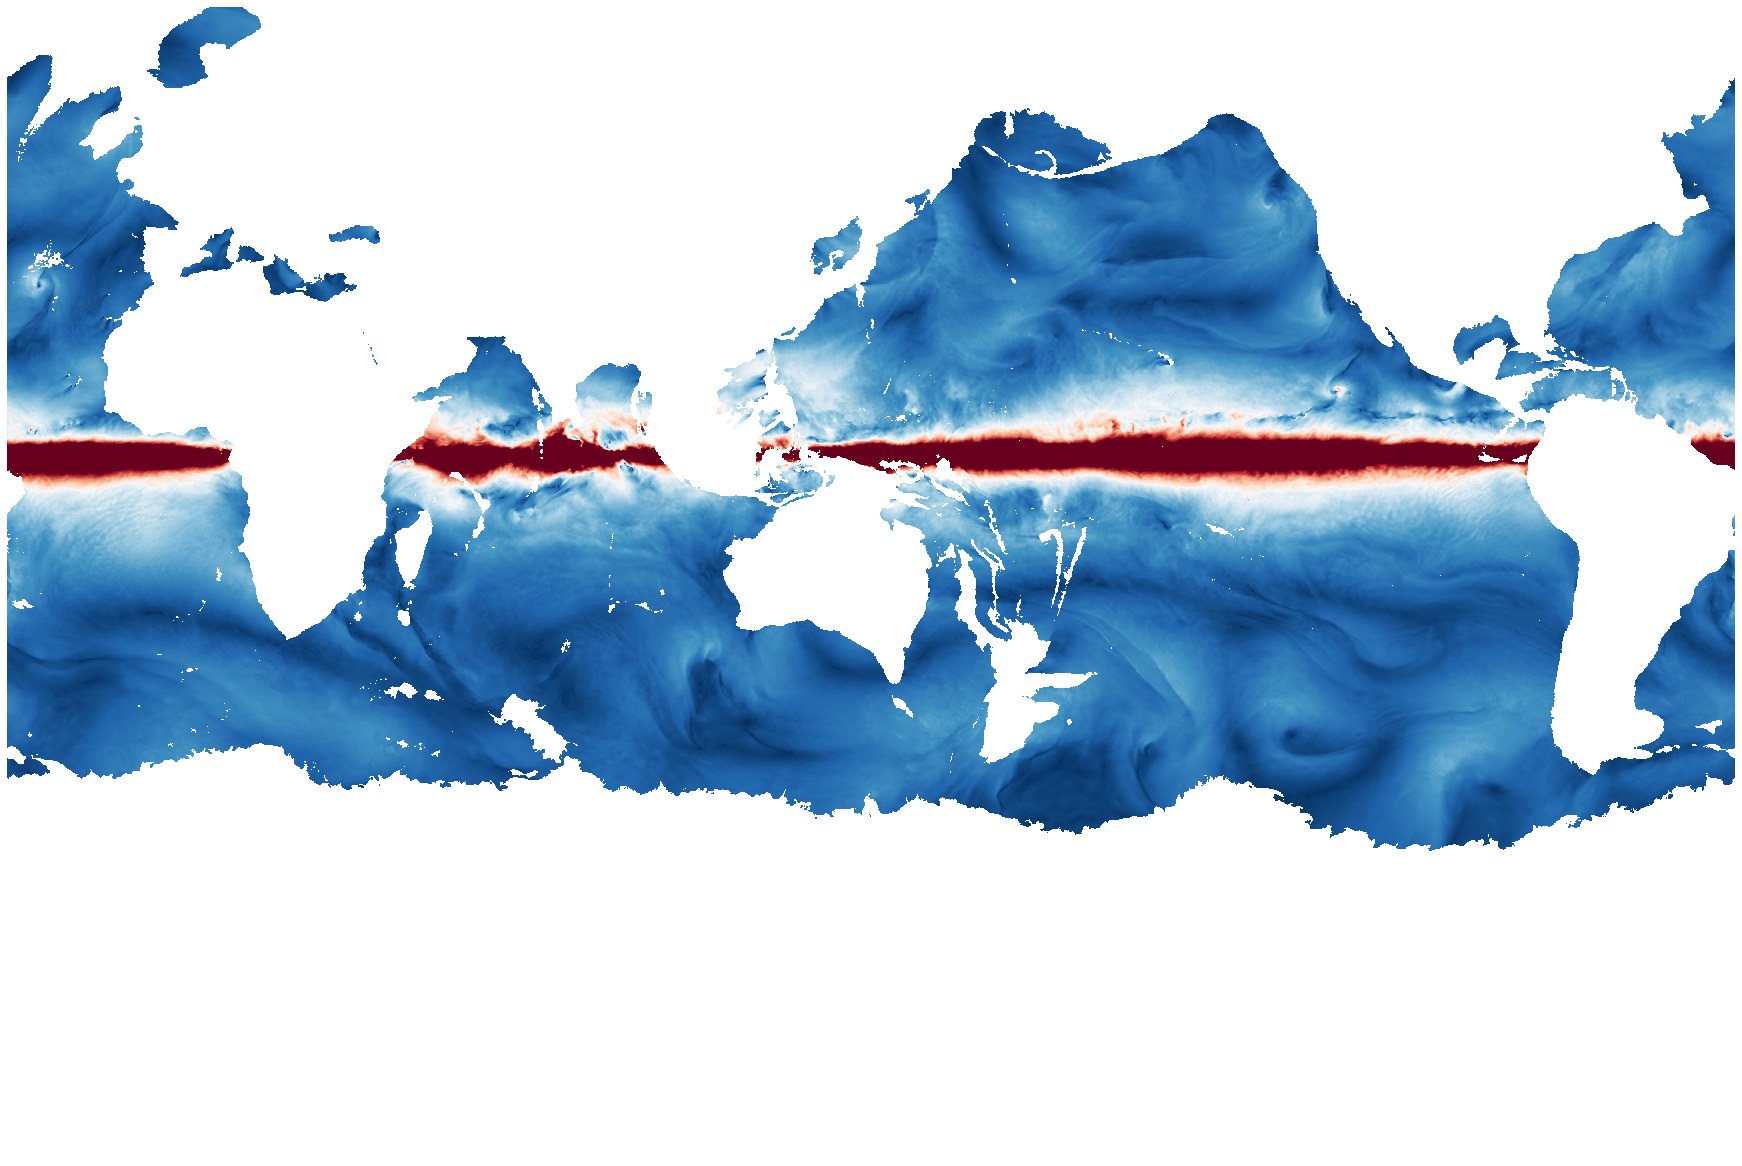

In [18]:
quick_llc_plot(ds_ELD.ELD.sel(time='2011-11-24T08:00:00').where( (ice.AREA>0)&(ds_ELD.Depth>2000) ), vmin=0, vmax=200, add_colorbar=False, axis_off=True, cmap = 'RdBu_r')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the

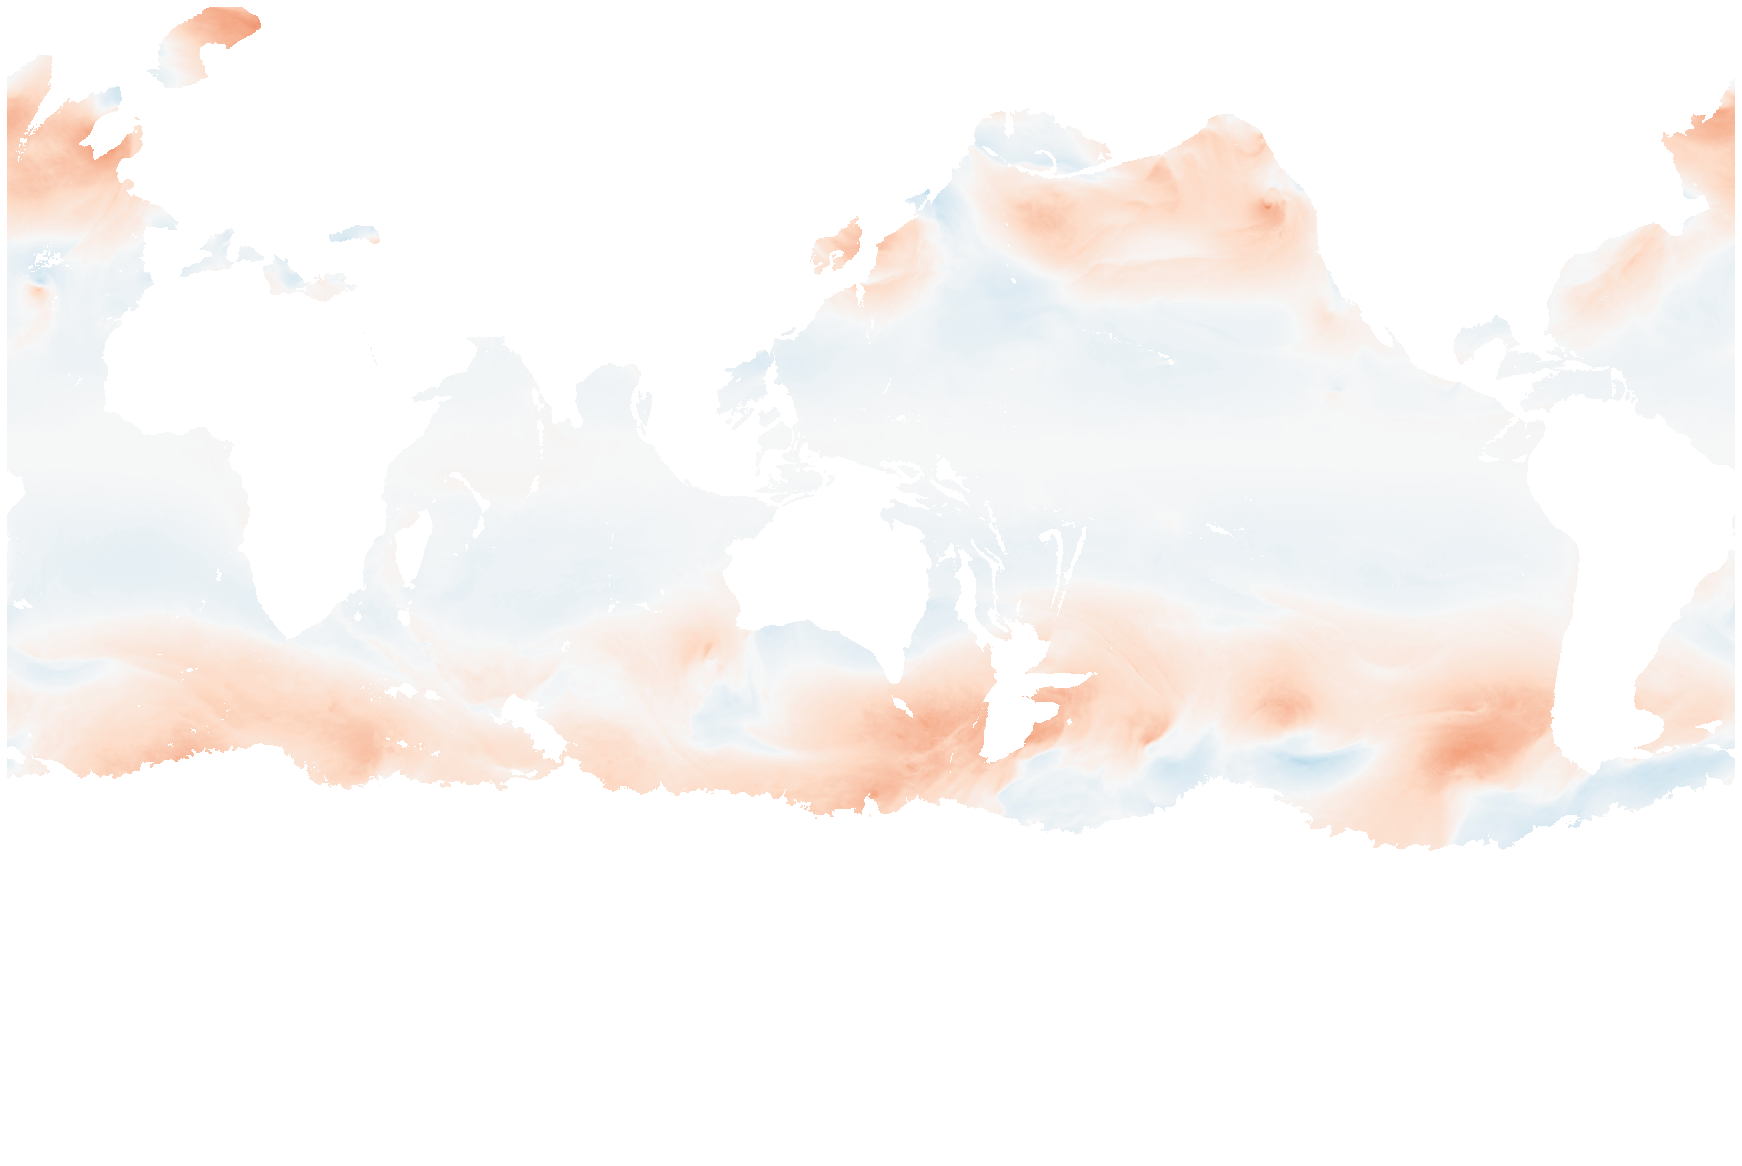

In [19]:
quick_llc_plot(ds_TAUX_ELD_rotation.oceTAUX_H.sel(time='2011-11-24T08:00:00').where( (ice.AREA>0)&(ds_ELD.Depth>2000) ), vmin=-4e-5, vmax=4e-5, add_colorbar=False, axis_off=True, cmap = 'RdBu_r')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the

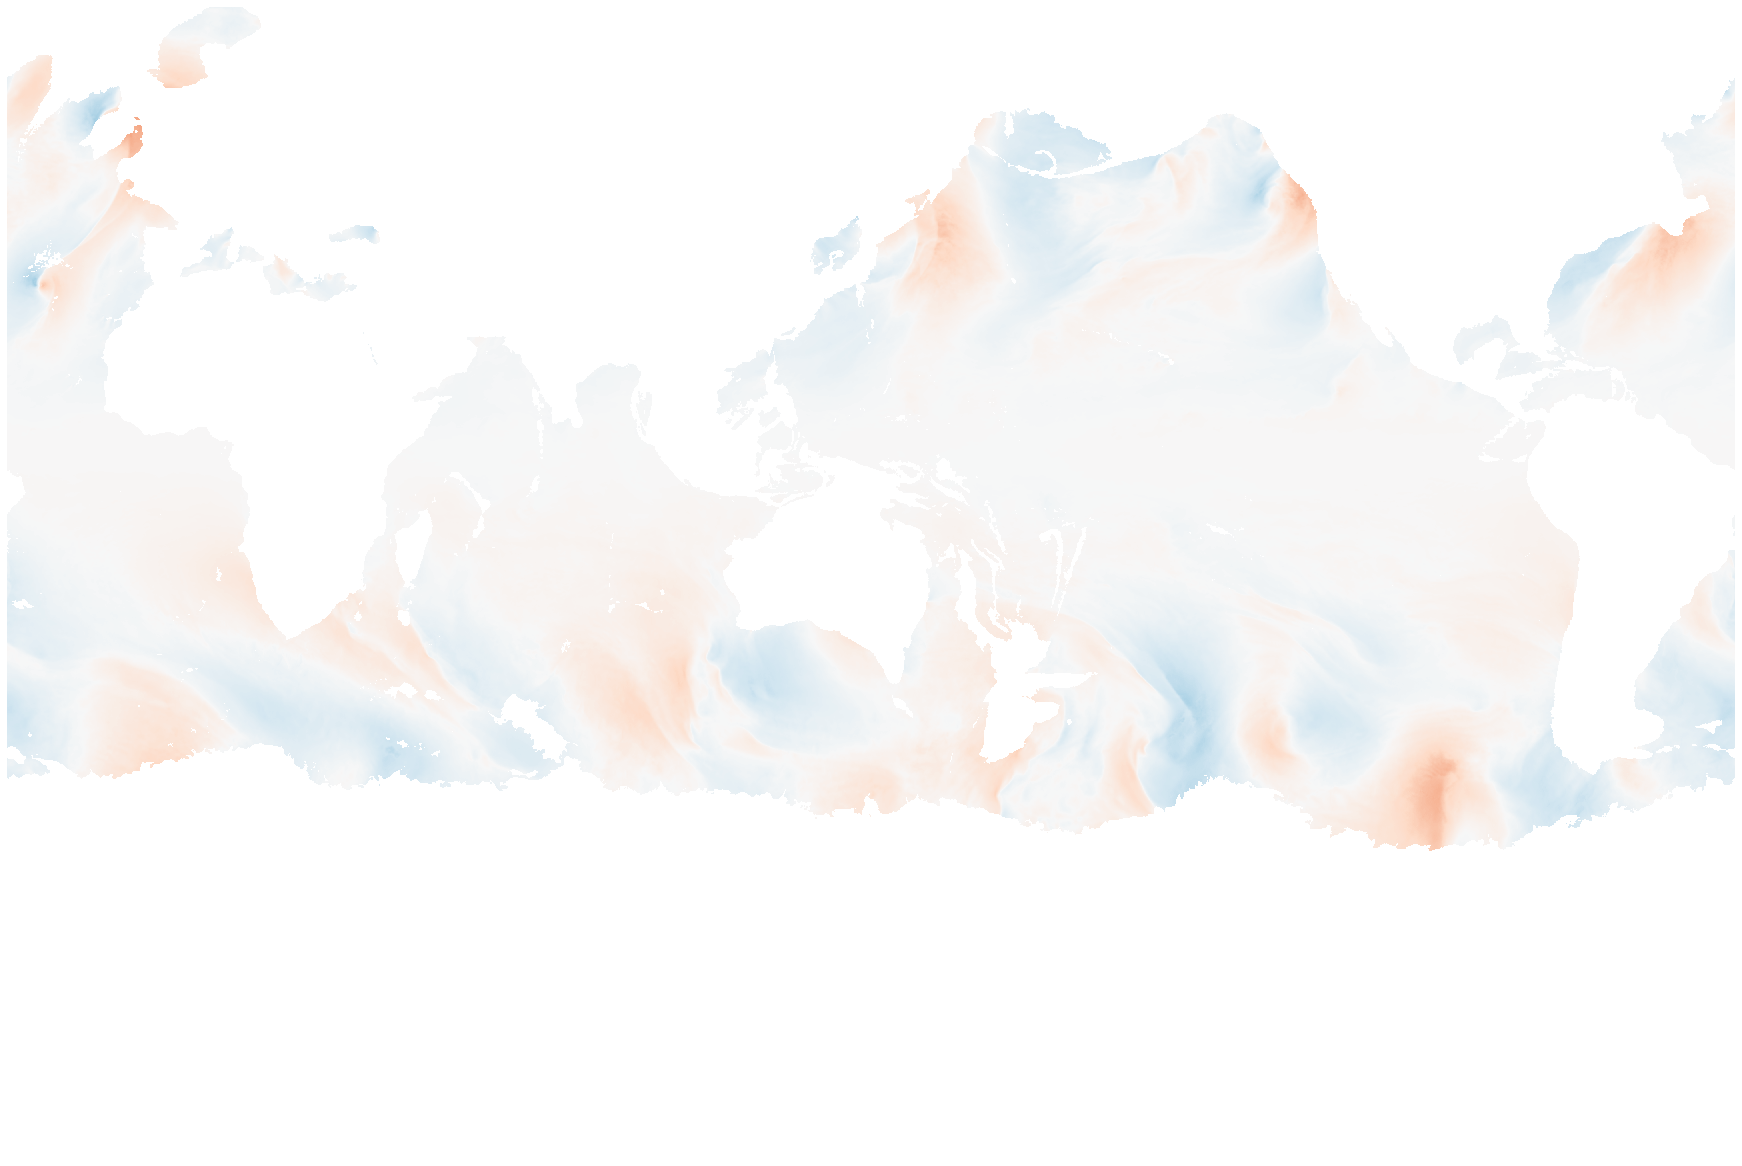

In [20]:
quick_llc_plot(ds_TAUY_ELD_rotation.oceTAUY_H.sel(time='2011-11-24T08:00:00').where( (ice.AREA>0)&(ds_ELD.Depth>2000) ), vmin=-4e-5, vmax=4e-5, add_colorbar=False, axis_off=True, cmap = 'RdBu_r')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the

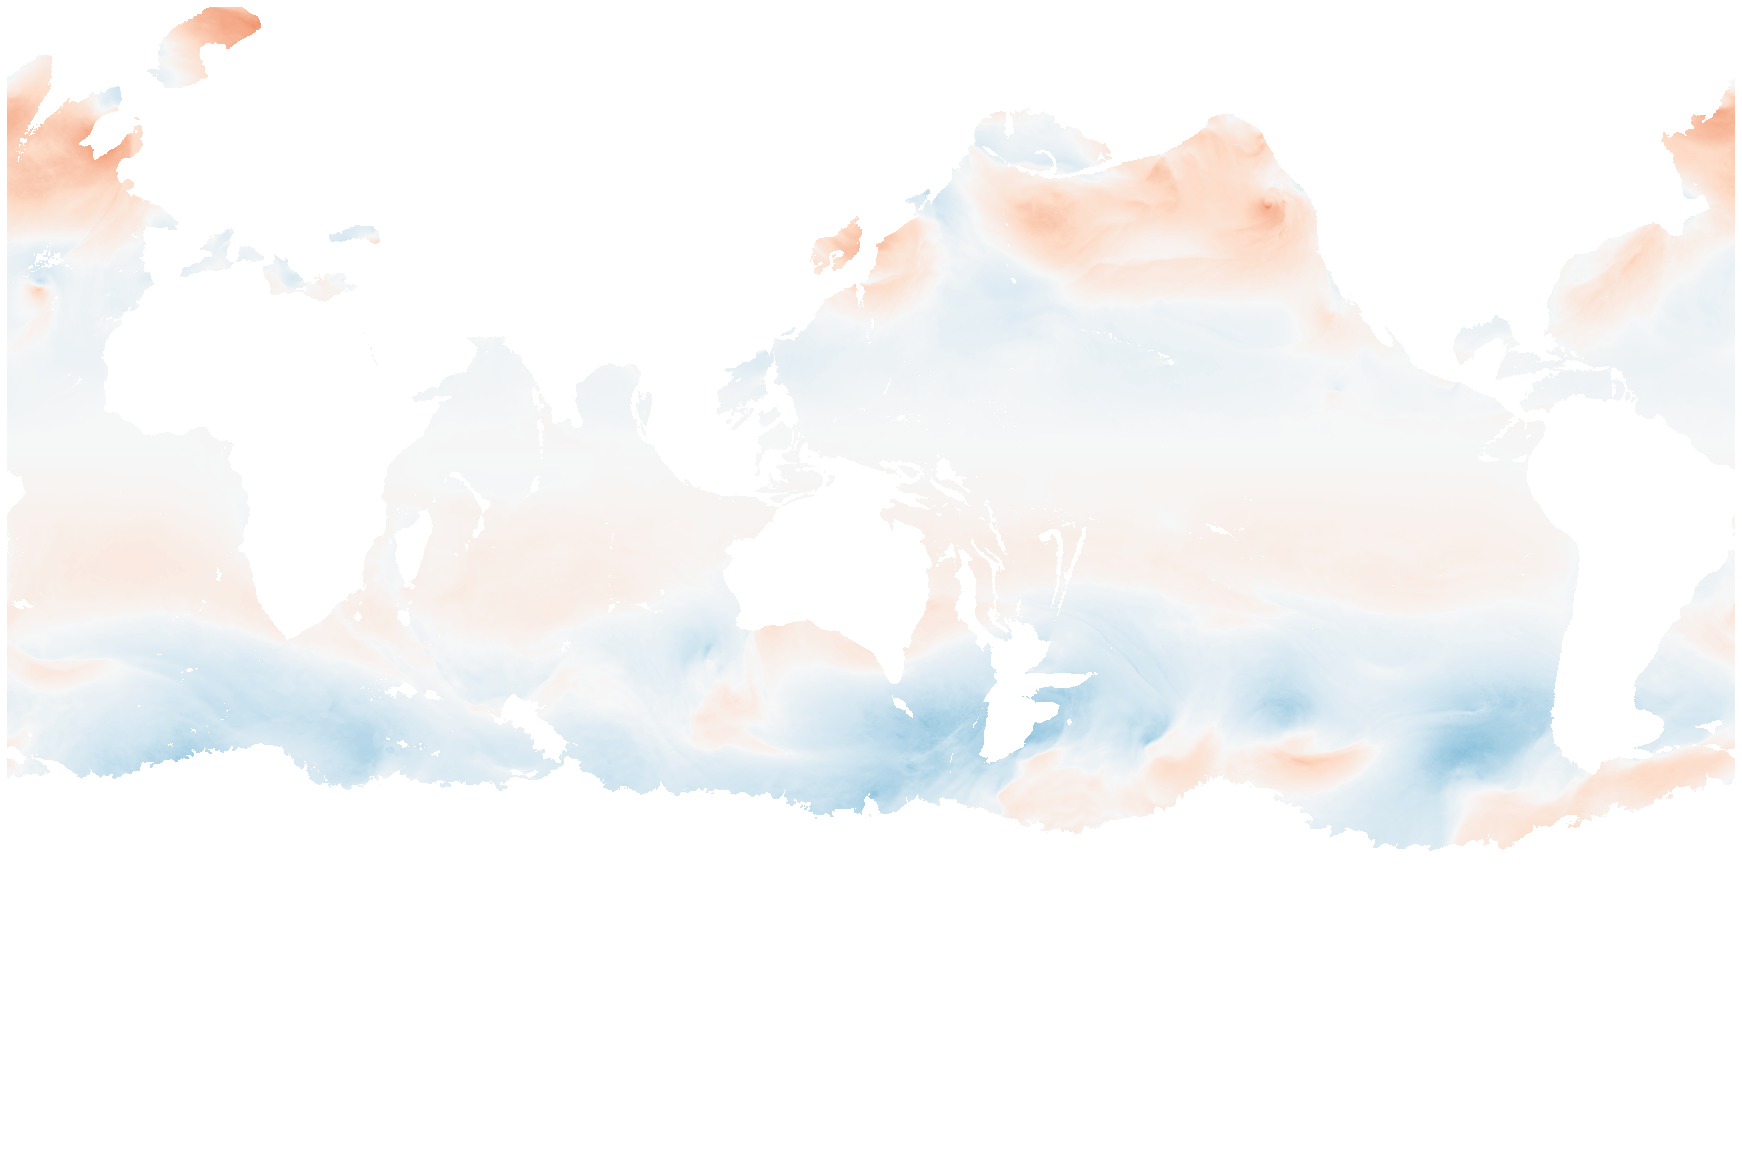

In [21]:
quick_llc_plot(ds_TAUX_ELD_rotation.oceTAUX_H.sel(time='2011-11-24T08:00:00')*(f_ij)/np.abs(f_ij).where( (ice.AREA>0)&(ds_ELD.Depth>2000) ), vmin=-4e-5, vmax=4e-5, add_colorbar=False, axis_off=True, cmap = 'RdBu_r')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the

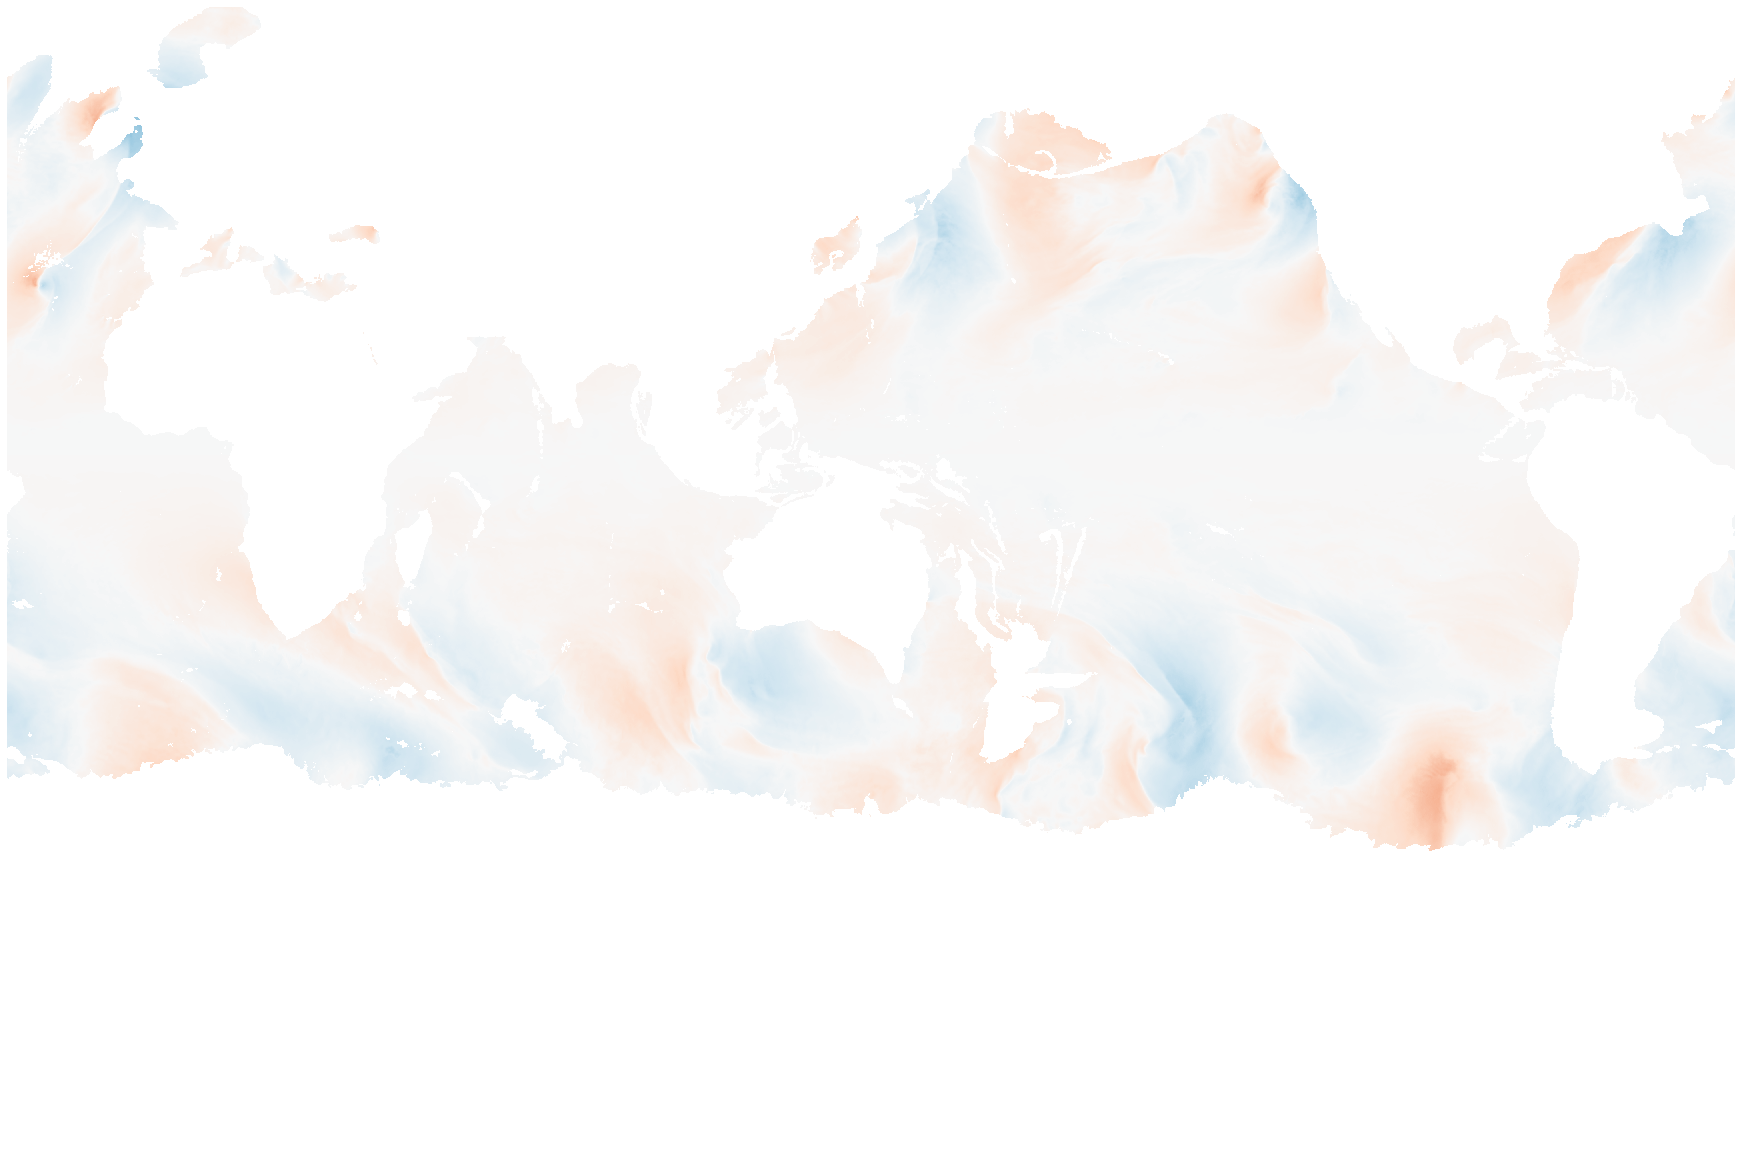

In [23]:
quick_llc_plot(ds_TAUY_ELD_rotation.oceTAUY_H.sel(time='2011-11-24T08:00:00')*(-f_ij)/np.abs(f_ij).where( (ice.AREA>0)&(ds_ELD.Depth>2000) ), vmin=-4e-5, vmax=4e-5, add_colorbar=False, axis_off=True, cmap = 'RdBu_r')

In [ ]:
cluster.close()

________________

# Part 2: RMS


In [11]:
out_dir_zarr = '/home/datawork-lops-osi/equinox/mit4320/zarr/'
store_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/TAU/'

# read rechunked data
grid = xr.open_zarr(out_dir_zarr+'grid.zarr')
ds_TAUX = xr.open_zarr(out_dir_zarr+'oceTAUX.zarr').rename({'i_g': 'i'}).isel(time=slice(0,None,24))
ds_TAUY = xr.open_zarr(out_dir_zarr+'oceTAUY.zarr').rename({'j_g': 'j'}).isel(time=slice(0,None,24))

# data merge
ds = xr.merge([ds_TAUX,ds_TAUY,grid])
print(ds)

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 358)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(9,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-11-23T08:00:00 ... 2012-11-14T08:00:00
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    PHrefC   (k) float32 dask.array<chunksize=(90,), meta=np.ndarray>
    PHrefF   (k_p1) float32 dask.array<chunksize=(91,), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
 

In [12]:
grid = xgcm.Grid(ds, coords={'X':{'center':'i', 'left':'i_g'},
                              'Y':{'center':'j', 'left':'j_g'}}, periodic=['X', 'Y'])

store_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/TAU/'

In [13]:
# coriolis term
lat = ds['YC']
omega = 7.3/100000
f_ij = 2*omega*np.sin(np.deg2rad(lat))
f_ij

<xarray.DataArray 'YC' (face: 13, j: 4320, i: 4320)>
dask.array<mul, shape=(13, 4320, 4320), dtype=float32, chunksize=(1, 4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rA       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

In [15]:
overwrite=True
    
for face in range(13):
#for face in [1]:

    Efile = store_dir_zarr+'TAU_ELD_rms_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:
        
        oceTAUX_rotation =  ds.oceTAUX.isel(face=face)*ds.CS.isel(face=face) - ds.oceTAUY.isel(face=face)*ds.SN.isel(face=face)
        oceTAUY_rotation =  ds.oceTAUX.isel(face=face)*ds.SN.isel(face=face) + ds.oceTAUY.isel(face=face)*ds.CS.isel(face=face)
        ELD = 0.2*np.sqrt(np.sqrt(oceTAUX_rotation**2 + oceTAUY_rotation**2)/1025)/np.abs(f_ij.isel(face=face))        
        
        oceTAUX_H_rms = ( (oceTAUX_rotation.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/ELD.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/f_ij.isel(face=face,i=slice(0, None, 4),j=slice(0 ,None, 4))/1025 )**2 ).mean(['time'])
        chunks = {'i': 108, 'j': 108}
        oceTAUX_H_rms = oceTAUX_H_rms.chunk(chunks)
        oceTAUX_H_rms = np.real(oceTAUX_H_rms).rename('oceTAUX_ELD_rms')
        
        oceTAUY_H_rms = ( (oceTAUY_rotation.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/ELD.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/f_ij.isel(face=face,i=slice(0, None, 4),j=slice(0 ,None, 4))/1025 )**2 ).mean(['time'])
        chunks = {'i': 108, 'j': 108}
        oceTAUY_H_rms = oceTAUY_H_rms.chunk(chunks)        
        oceTAUY_H_rms = np.real(oceTAUY_H_rms).rename('oceTAUY_ELD_rms')
        
        oceTAU_H_rms = xr.merge([oceTAUX_H_rms, oceTAUY_H_rms])
        # store
        #oceTAUX_H_rms = np.real(oceTAUX_H_rms).rename('oceTAUX_ELD_rms')
        #oceTAUX_H_rms = oceTAUX_H_rms.to_dataset()
        #print(oceTAU_H_rms)
        
        for c in oceTAU_H_rms.coords:
            try:
                del E[c].encoding['chunks']
            except:
                pass        
        
        %time oceTAU_H_rms.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

CPU times: user 8.68 s, sys: 416 ms, total: 9.09 s
Wall time: 31.8 s
--- face 0 done
CPU times: user 9.47 s, sys: 628 ms, total: 10.1 s
Wall time: 36.4 s
--- face 1 done
CPU times: user 9.5 s, sys: 544 ms, total: 10 s
Wall time: 36.8 s
--- face 2 done
CPU times: user 9.2 s, sys: 664 ms, total: 9.86 s
Wall time: 35.8 s
--- face 3 done
CPU times: user 9.5 s, sys: 548 ms, total: 10 s
Wall time: 35 s
--- face 4 done
CPU times: user 8.94 s, sys: 488 ms, total: 9.42 s
Wall time: 33.5 s
--- face 5 done
CPU times: user 9.26 s, sys: 424 ms, total: 9.68 s
Wall time: 34.8 s
--- face 6 done
CPU times: user 8.99 s, sys: 512 ms, total: 9.5 s
Wall time: 33.3 s
--- face 7 done
CPU times: user 8.84 s, sys: 456 ms, total: 9.3 s
Wall time: 32.4 s
--- face 8 done
CPU times: user 9.46 s, sys: 508 ms, total: 9.97 s
Wall time: 34.5 s
--- face 9 done
CPU times: user 9.4 s, sys: 560 ms, total: 9.96 s
Wall time: 35 s
--- face 10 done
CPU times: user 9.17 s, sys: 456 ms, total: 9.63 s
Wall time: 32.1 s
--- face 

In [16]:
store_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/TAU/'
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

D = [xr.open_zarr(store_dir_zarr+'TAU_ELD_rms_f%02d.zarr'%(face)) for face in face_all] 
ds_TAU_ELD = xr.concat(D, dim='face')
ds_TAU_ELD 

<xarray.Dataset>
Dimensions:          (face: 13, i: 1080, j: 1080)
Coordinates:
  * i                (i) int64 0 4 8 12 16 20 ... 4296 4300 4304 4308 4312 4316
  * j                (j) int64 0 4 8 12 16 20 ... 4296 4300 4304 4308 4312 4316
    CS               (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
    Depth            (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
    SN               (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
    XC               (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
    YC               (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
  * face             (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    rA               (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
Data variables:
    oceTAUX_ELD_rms  (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
    oceTAUY_ELD_

In [20]:
Efile = store_dir_zarr+'TAU_ELD_rms.zarr'
ds_TAU_ELD.to_zarr(Efile, mode='w')

In [17]:
def quick_llc_plot(data, axis_off=False, **kwargs):
    face_to_axis = {0: (2, 0), 1: (1, 0), 2: (0, 0),
                    3: (2, 1), 4: (1, 1), 5: (0, 1),
                    7: (0, 2), 8: (1, 2), 9: (2, 2),
                    10: (0, 3), 11: (1, 3), 12: (2, 3)}
    transpose = [7, 8, 9, 10, 11, 12]
    gridspec_kw = dict(left=0, bottom=0, right=4, top=4, wspace=0, hspace=0)
    fig, axes = plt.subplots(nrows=3, ncols=4, gridspec_kw=gridspec_kw)
    for face, (j, i) in face_to_axis.items():
        data_ax = data.isel(face=face)
        ax = axes[j,i]
        yincrease = True
        if face in transpose:
            data_ax = data_ax.transpose()
            yincrease = False
        data_ax.plot(ax=ax, yincrease=yincrease, **kwargs)
        if axis_off:
            ax.axis('off')
        ax.set_title('')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the

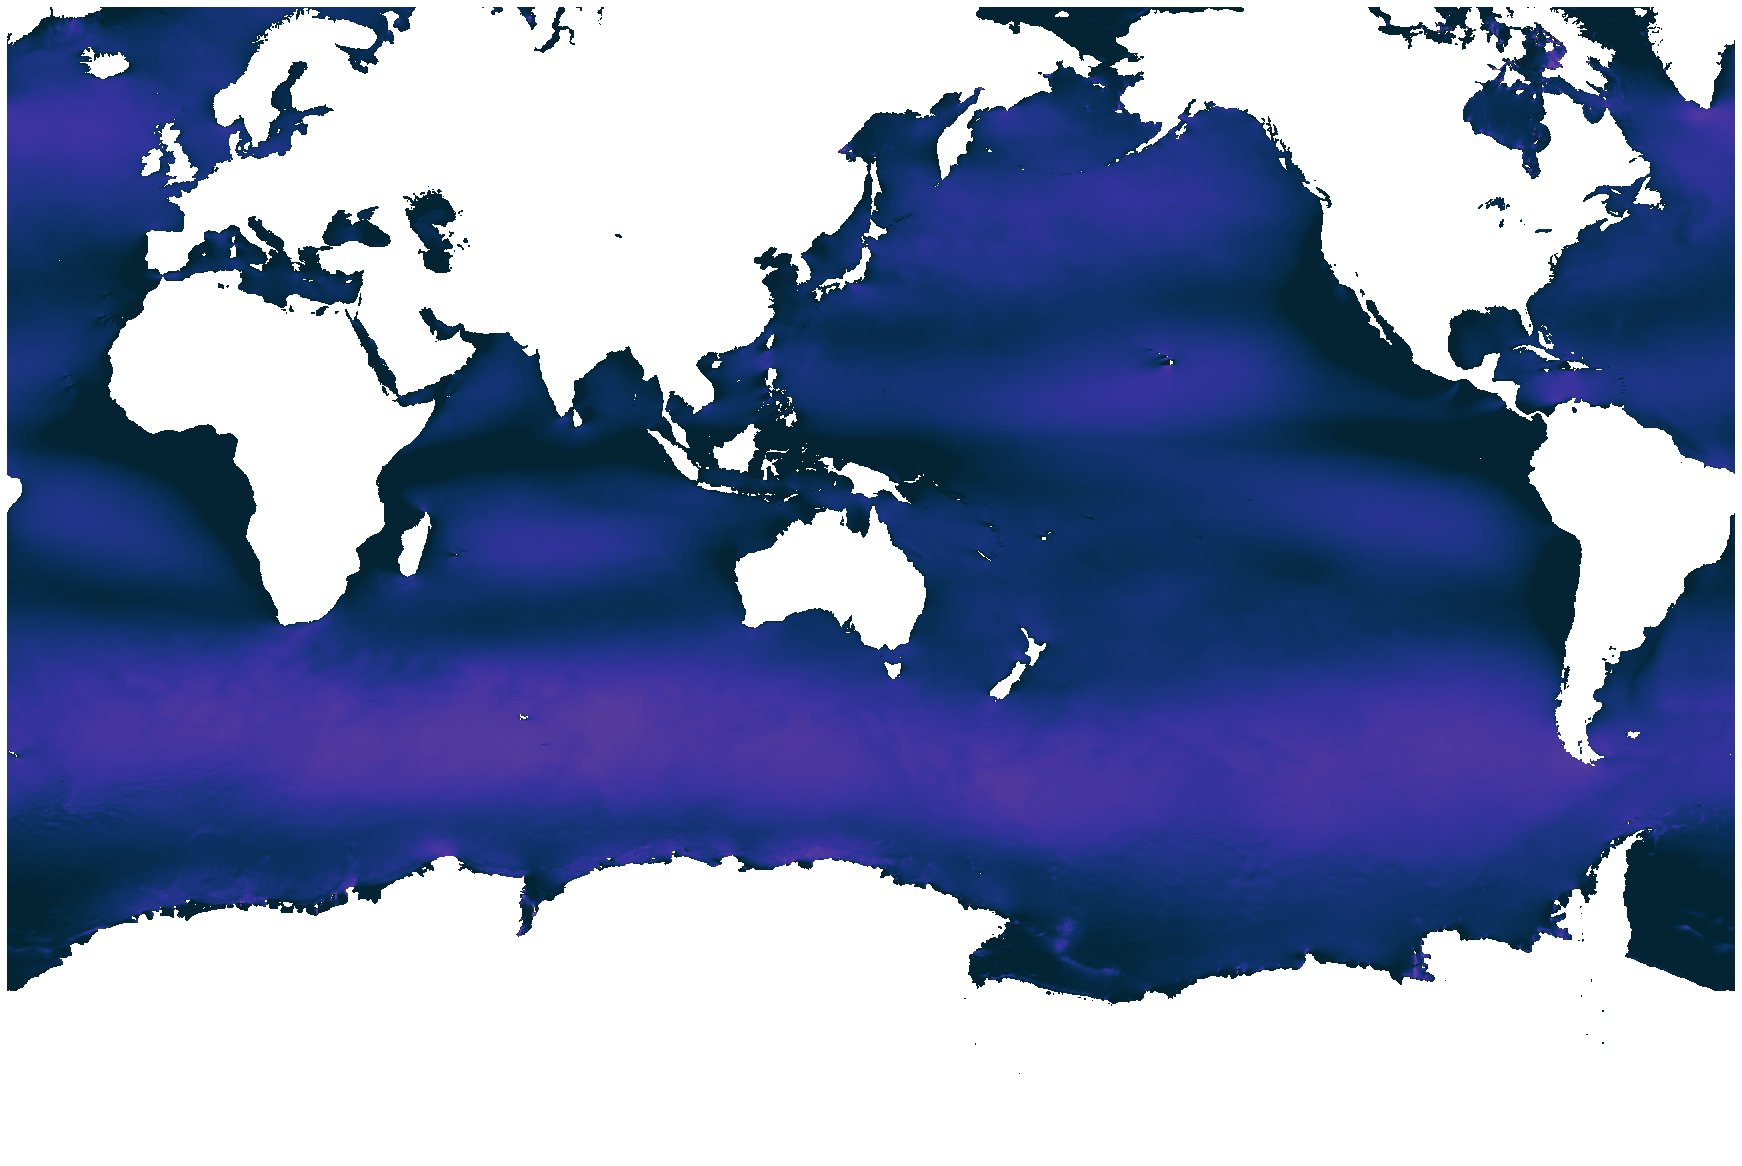

In [19]:
quick_llc_plot(np.log10(ds_TAU_ELD.oceTAUX_ELD_rms+ds_TAU_ELD.oceTAUX_ELD_rms), vmin=-3, vmax=1, add_colorbar=False, axis_off=True, cmap = cm.thermal)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the

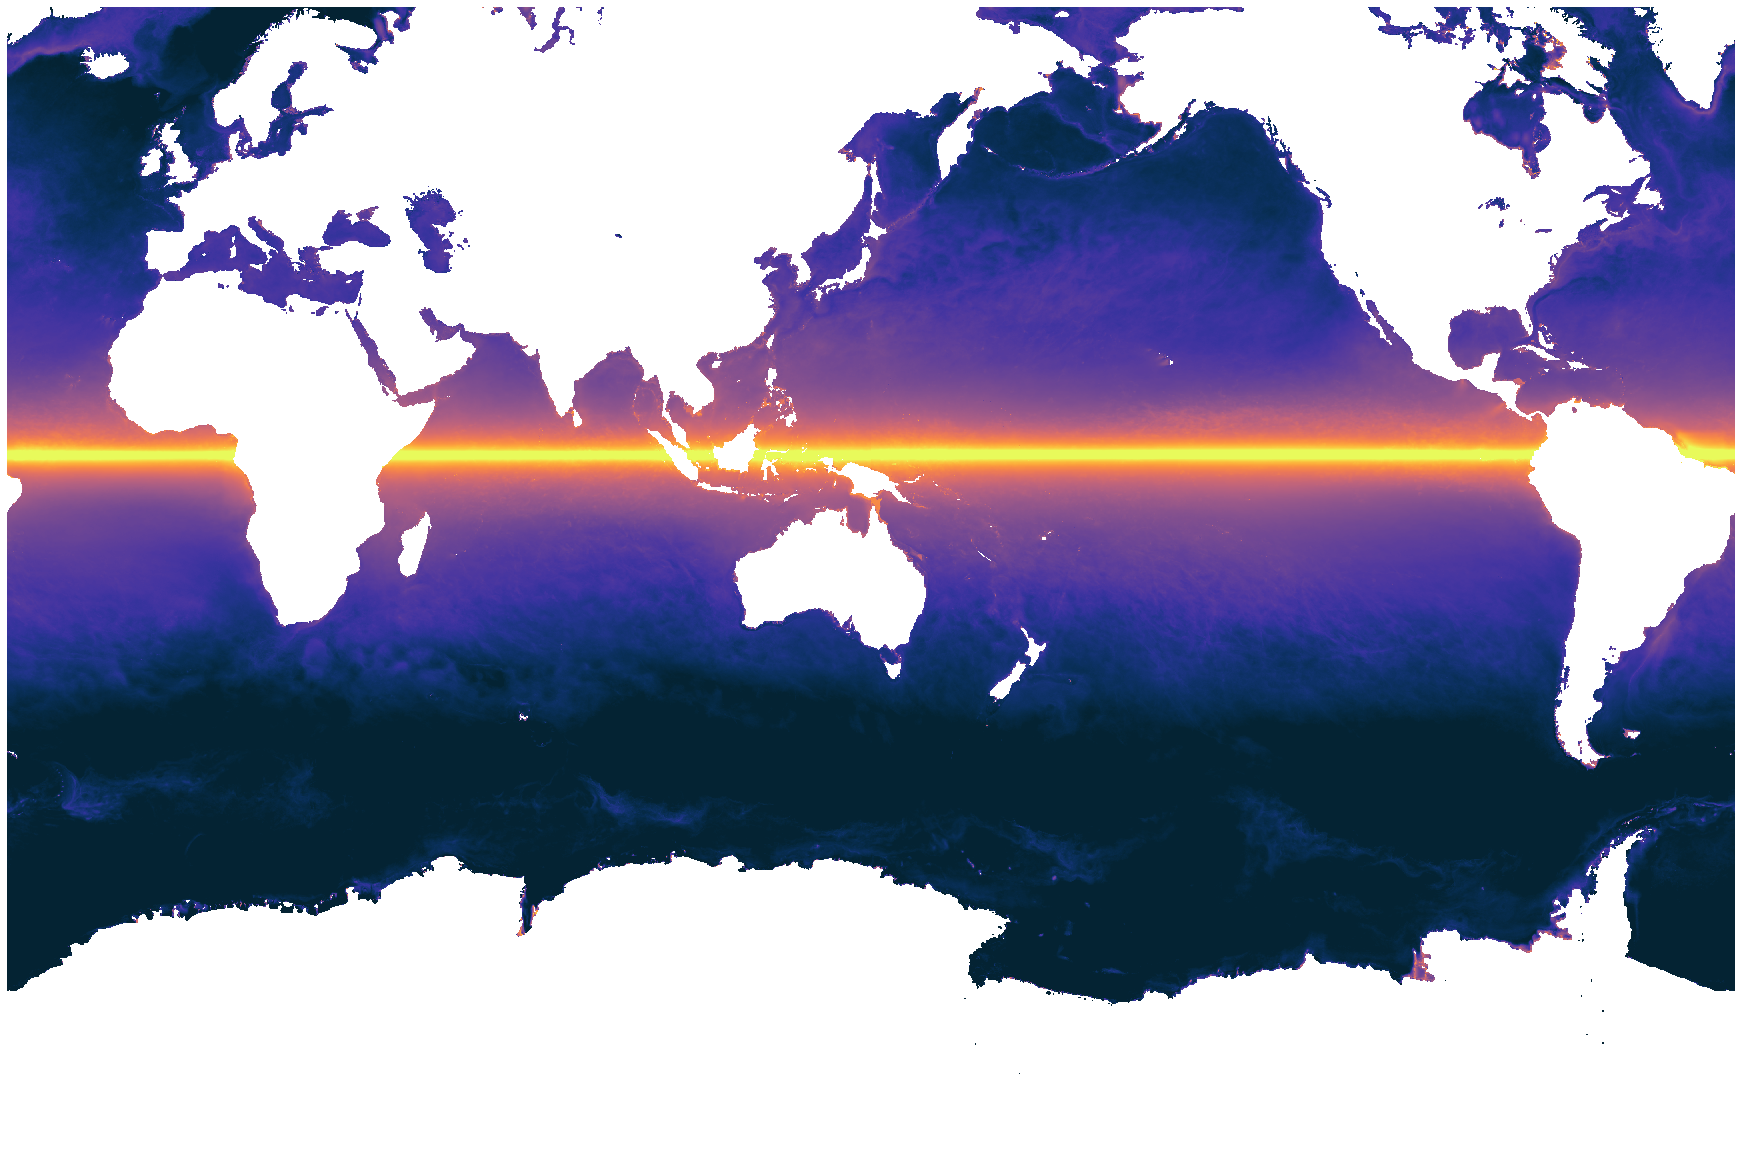

In [33]:
quick_llc_plot(np.log10(dds_TAU_ELD.oceTAUX_ELD_rms+ds_TAU_ELD.oceTAUX_ELD_rms), vmin=-3, vmax=1, add_colorbar=False, axis_off=True, cmap = cm.thermal)

In [24]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1005, in _reconnect
    await self._close()
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1